In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import convolve
from scipy.stats import gamma
from pathlib import Path
from tqdm import tqdm
import cv2
import glob
import h5py

In [2]:
def heaviside(x, center, width, epsilon=1.0):
    e1 = center - width/2
    e2 = center + width/2

    half1 = 0.5 + 0.5 * (2/np.pi) * np.arctan((x-e1)/epsilon)
    half2 = 1 - (0.5 + 0.5 * (2/np.pi) * np.arctan((x-e2)/epsilon))

    window = np.concatenate((half1[:center], half2[center:]))

    return window


def log_fn(x, a):
    y = a * np.log(x+1)
    return y


def aug_convolution(x, y, a, scale):
    x_k = np.linspace(0, 10, len(x))
    kernel = gamma.pdf(x_k, a, scale=scale)
    y_aug = convolve(y, kernel, mode='full') / sum(kernel)

    return y_aug


def random_waveform(num_samples, num_components, t_max):
    # Generate random frequencies, phases, and amplitudes for each component
    frequencies = np.random.uniform(0.5, 2, num_components)  # Random frequencies between 0.5 and 2 Hz
    phases = np.random.uniform(0, 2*np.pi, num_components)  # Random phases between 0 and 2*pi
    amplitudes = np.random.uniform(0.02, 0.025, num_components)  # Random amplitudes between 0.5 and 2

    # Time array
    time = np.linspace(0, t_max, num_samples)

    # Generate waveform by summing sine and cosine components
    waveform = np.zeros(num_samples)
    for i in range(num_components):
        waveform += amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * time + phases[i])  # Add sine component
        waveform += amplitudes[i] * np.cos(2 * np.pi * frequencies[i] * time + phases[i])  # Add cosine component

    return waveform

In [3]:
def augmentations(image):
    img = np.copy(image)
    img = img / np.max(img) # Normalize to the maximum
    kernel_size = 5   # Kernel size for the medial filtering
    img = cv2.medianBlur(img, kernel_size) # Median filtering for cleaning up the data
    img_aug = np.copy(img)

    tx = np.random.randint(-80,80) # define the range of values to shift the images in x direction
    ty = np.random.randint(-50,50) # define the range of values to shift the images in y direction
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]]) 
    translated_image = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0])) # apply random translation to the image

    x = np.array([i for i in range(img.shape[1])])
    w = np.array([i for i in range(img.shape[-1])])

    window_center = np.random.randint(img.shape[-1]/3, img.shape[-1] * 2 / 3) # chose a random value to be the center of the augmentation window
    window_width = np.random.randint(50, 150)                                 # chose a random value to be the width of the augmentation window
    epsilon = np.random.randint(8, 15)                                        # this defines the sharpness of the edges. Larger value means broader edges
    amplitude = np.random.uniform(0.5,1)                                      # chose an amplitude between 0.5 and 1.0
    window = heaviside(w, window_center, window_width, epsilon=epsilon) * amplitude      # The window will have non-zero values for the augmentation window

    conv_a = 1                                                         # asymmetry parameter (1 is the best suiting)
    scale = window * (1 + random_waveform(len(window), 10, t_max=40))  # random wavelform function to make the convolution more noisy. increasing t_max would increase the frequency of the noise

    for i in range(len(w)):
        # scale_aug = scale[i] * (1 + random_waveform(len(window), 10))[i]
        y = translated_image.T[i]
        y_aug = aug_convolution(x, y, conv_a, scale[i])
        idx = int(log_fn(scale[i], *params))   # convolution shifts the peak from the original position. idx is the number of pixels it need to be shifted back
        img_aug.T[i] = y_aug[idx:idx + len(y)] * (1 + (random_waveform(len(y), 10, t_max=10) * scale[i]))

    M, N = (np.array(img.shape) // 5)
    img = cv2.resize(translated_image, (N, M))
    img_aug = cv2.resize(img_aug, (N, M))

    return img, img_aug


In [22]:
def make_train_data(filepath, run_id, date):
    
    train_X = []
    train_Y = []
    
    for r_id in tqdm(run_id, desc='Runs'):
        filestr = glob.glob(filepath+f'/*run{r_id}*{date}*')[0]
        with h5py.File(filestr,'r') as fi:
            imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'])[:,120:,:].astype(np.float32)
            for im in tqdm(imarr[:], desc='Images'):
                imgy, imgx = augmentations(im)
                train_X.append(imgx)
                train_Y.append(imgy)

    print(f"Size of the training set : {len(train_X)}")
    return train_X, train_Y

In [23]:
s = [0, 0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
ii = [0, 5, 15, 25, 35, 40, 45, 50, 55, 60, 70]
params, cov = curve_fit(log_fn, s, ii, p0=[40])

In [24]:
filepath = '/asap3/flash/gpfs/fl21/2023/data/11019168/raw/hdf/online-0/fl2user2/'
datestr = '20231121'
run_id = [49473, 49477, 49487, 49489] # [50627, 50631]
train_X, train_Y = make_train_data(filepath, run_id, datestr)

train_data = pd.DataFrame({'train_X' : train_X , 'train_Y' : train_Y})
train_data.to_pickle(f"data/train_data_{run_id}.pkl")

Runs: 100%|██████████| 4/4 [5:02:00<00:00, 4530.09s/it]  


Size of the training set : 8570


# Playground

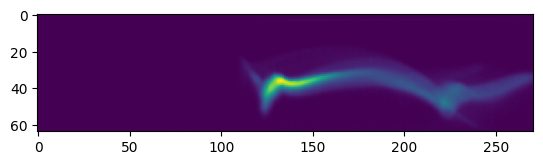

In [13]:
plt.imshow(train_X[6])

In [87]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50627}*20240125*')[0]

with h5py.File(filestr,'r') as fi:
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][1000])

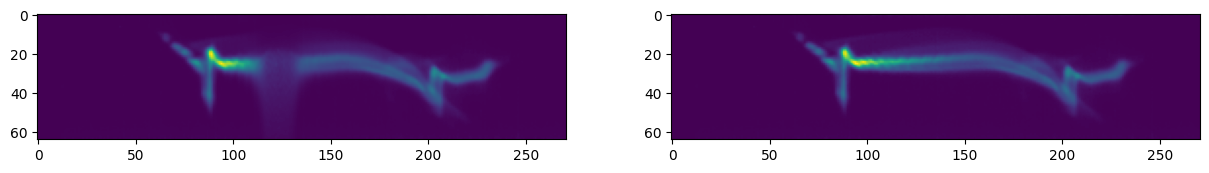

In [30]:
#im, im_aug = augmentations(imarr.astype(np.float32))
fig,ax = plt.subplots(1,2, figsize=(15,45))
idx = 6000
ax[0].imshow(train_X[idx])
ax[1].imshow(train_Y[idx])
#ax[2].imshow(im_aug)

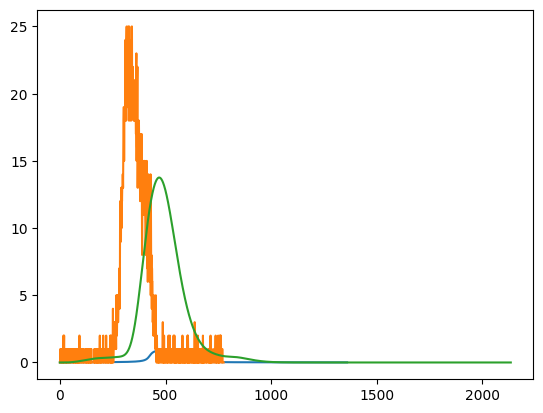

In [80]:
window = heaviside(w, 500, 150, epsilon=15)
plt.plot(window)
x = np.array([i for i in range(imarr.shape[1])])
y = imarr.T[600]
y1 = aug_convolution(x, y, 5, 0.2)
plt.plot(y)
plt.plot(y1)

In [4]:
train_data = pd.read_pickle("traindata.pkl")

In [6]:
trainX = train_data["train_Y"]
trainY = train_data["train_X"]

In [10]:
train_data = pd.DataFrame({'train_X' : trainX , 'train_Y' : trainY})
train_data.to_pickle(f"data/train_data_20231108.pkl")